<a href="https://colab.research.google.com/github/rogerpogg1/MVP-Sprint-Machine-Learning-e-Analytics/blob/main/RogerPoggi_MVP_MachineLearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### *Configurações de ambiente*

- *Importação das bibliotecas necessárias*

In [ ]:
# Módulos built-in
import warnings
warnings.filterwarnings("ignore")

# Análise de dados
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Machine learning
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor
from sklearn.linear_model import ElasticNetCV
from sklearn.feature_selection import SelectPercentile, f_regression, mutual_info_regression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.neural_network import MLPRegressor
from sklearn.compose import ColumnTransformer
from sklearn.datasets import fetch_openml
from lightgbm import LGBMRegressor

# Outras importações (séries temporais)
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller, acf, pacf
from scipy.stats import linregress


%matplotlib inline

- *Versões utilizadas (para reprodutibilidade)*

In [ ]:
# Exibir versões das bibliotecas
print("numpy:", np.__version__)
print("pandas:", pd.__version__)
print("matplotlib:", plt.matplotlib.__version__)
print("seaborn:", sns.__version__)
import sklearn
print("scikit-learn:", sklearn.__version__)
import lightgbm
print("lightgbm:", lightgbm.__version__)
import scipy
print("scipy:", scipy.__version__)
import statsmodels
print("statsmodels:", statsmodels.__version__)

# pip install numpy==2.3.2 pandas==2.3.1 matplotlib==3.10.5 seaborn==0.13.2 scikit-learn==1.7.1 lightgbm==4.6.0 scipy==1.16.1 statsmodels==0.14.5

numpy: 2.3.2
pandas: 2.3.1
matplotlib: 3.10.5
seaborn: 0.13.2
scikit-learn: 1.7.1
lightgbm: 4.6.0
scipy: 1.16.1
statsmodels: 0.14.5


- *Funções de utilidade*

In [ ]:
def cross_val_scores_boxplot(data: np.ndarray, labels: list = None) -> None:
    """
    Draw a box and whisker plot for the cross validation scores.

    Parameters
    ----------
    data : array-like
        The input data.

    labels : list
        Labels for each dataset (one per dataset).
    """
    # Create a figure and a set of subplots
    fig, ax = plt.subplots(figsize=(20, 10))

    # A dictionary mapping each component of the boxplot
    # to a list of the .Line2D instances created
    flier = dict(markerfacecolor="orange", marker="D", markersize=12)
    median = dict(linewidth=5, color="orange")
    whisker = dict(linewidth=2.5, color="#F9E4C8")
    mean = dict(markerfacecolor="green", marker="D", markersize=8)

    # Draw a box and whisker plot for the cross validation scores
    bplots = ax.boxplot(
        x=data,
        labels=labels,
        flierprops=flier,
        patch_artist=True,
        medianprops=median,
        whiskerprops=whisker,
        capprops=whisker,
        showmeans=True,
        meanprops=mean,
    )
    # customized patches
    colors = ["#F9E4C8" for i in range(0, len(data))]
    for patch, color in zip(bplots["boxes"], colors):
        patch.set_facecolor(color)
        patch.set_alpha(0.5)
        patch.set_edgecolor("black")

    # horizontal grid lines
    ax.yaxis.grid(True)

    # add a title to the Axes
    plt.title("Algorithm Comparison")
    plt.show()


def plot_cross_val_scores(
    models: list,
    X: np.ndarray,
    y: np.ndarray,
    cv=None,
    scoring=None,
) -> None:
    """
    Draw a box and whisker plot to evaluate scores by cross-validation.

    Parameters
    ----------
    models : list
        Models (or pipelines) to evaluate.

    X : array-like of shape (n_samples, n_features)
        The data matrix.

    y : array-like of shape (n_samples,)
        The target vector.

    cv : int, cross-validation generator or an iterable, optional, Defaults to None.
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:

        - None, to use the default 5-fold cross-validation,
        - integer, to specify the number of folds.
        - ``CV splitter``
        - An iterable yielding (train, test) splits as arrays of indices.

    scoring : str, callable, optional, Defaults to None
        A string (see https://scikit-learn.org/stable/modules/model_evaluation.html) or
        a scorer callable object / function with signature scorer(estimator, X, y).
    """
    results, names = [], []

    for name, model in models:
        cv_results = cross_val_score(model, X, y, cv=cv, scoring=scoring)
        results.append(cv_results)
        names.append(name)
        print("%s: %f (%f)" % (name, cv_results.mean(), cv_results.std()))

    cross_val_scores_boxplot(data=results, labels=names)


def adf_test(data: np.ndarray) -> None:
    """
    Check if Time Series Data is Stationary by
    applying the ``Augmented Dickey-Fuller test``.

    The Augmented Dickey-Fuller test can be used to test for a
    unit root in a univariate process in the presence of serial correlation.

    The intuition behind a unit root test is that it determines
    how strongly a time series is defined by a trend.

    Reference :

    https://machinelearningmastery.com/time-series-data-stationary-python/

    Parameters
    ----------
    data : array-like
        Array of time-series values.
    """
    # Augmented Dickey-Fuller test
    dftest = adfuller(data.dropna(), autolag="AIC")
    print(" > Is the raw data stationary ?")

    # The test statistic
    print("Test statistic = {:.3f}".format(dftest[0]))
    # MacKinnon's approximate p-value based on MacKinnon (1994, 2010)
    print("P-value = {:.3f}".format(dftest[1]))

    # Critical values for the test statistic at the 1 %, 5 %, and 10 % levels.
    # Based on MacKinnon (2010)
    print("Critical values :")
    for k, v in dftest[4].items():
        print(
            "\t{}: {} - The data is {} stationary with {}% confidence".format(
                k, v, "not" if v < dftest[0] else "", 100 - int(k[:-1])
            )
        )


def plot_cv_indices(
    X: np.ndarray,
    y: np.ndarray,
    cv: TimeSeriesSplit,
    n_splits: int = 5,
) -> None:
    """
    Create a sample plot for indices of a ``cross-validation`` object.

    Parameters
    ----------
    X : array-like or sparse matrix, shape (n_samples, n_features)
        The data matrix.

    y : array-like of shape (n_samples,)
        The target vector.

    cv : ``sklearn.model_selection.TimeSeriesSplit``
        Time Series cross-validator.

    n_splits : int, optional, Defaults to 5
        Number of splits. Must be at least 2.
    """
    # Create a figure and a set of subplots
    fig, ax = plt.subplots(1, 1, figsize=(11, 7))
    fig.tight_layout()

    cmap_cv = plt.cm.coolwarm

    # Generate the training/testing visualizations for each CV split
    for ii, (tr, tt) in enumerate(cv.split(X=X, y=y)):
        # Fill in indices with the training/test groups
        indices = np.array([np.nan] * len(X))
        indices[tt] = 1
        indices[tr] = 0
        # Visualize the results
        ax.scatter(
            range(len(indices)),
            [ii + 0.5] * len(indices),
            c=indices,
            marker="_",
            lw=10,
            cmap=cmap_cv,
            vmin=-0.2,
            vmax=1.2,
        )
    # set y and x axis
    ax.set(
        yticks=np.arange(n_splits + 2) + 0.5,
        xlabel="Sample index",
        ylabel="CV iteration",
        ylim=[n_splits + 0.2, -0.2],
    )
    from matplotlib.patches import Patch

    # place a legend on the Axes
    ax.legend(
        [Patch(color=cmap_cv(0.8)), Patch(color=cmap_cv(0.02))],
        ["Testing set", "Training set"],
        loc=(1.02, 0.8),
    )
    # add a title to the Axes
    ax.set_title("{}".format(type(cv).__name__), fontsize=15)


def regression_metrics(y_true: np.ndarray, y_pred: np.ndarray) -> dict:
    """
    Main regression metrics.
    """
    metrics = {
        "MAE": round(mean_absolute_error(y_true, y_pred), 2),
        "R²": round(r2_score(y_true, y_pred), 2),
        "RMSE": round(np.sqrt(mean_squared_error(y_true, y_pred)), 2),
        "BIAS": round((y_pred - y_true).mean(), 3),
    }
    return metrics

### Definição de Problema

O objetivo deste projeto é prever a **demanda horária de bicicletas** em um sistema de bike sharing com base em dados históricos. O desafio consiste em capturar padrões temporais complexos relacionados a fatores sazonais, horários do dia, dias da semana e condições climáticas, de forma a fornecer previsões confiáveis para apoiar o **planejamento operacional** e a **alocação eficiente de bicicletas**.

Este problema se enquadra na categoria de **regressão em séries temporais**, onde a variável alvo é contínua (demanda de bicicletas) e há dependência temporal entre observações consecutivas.

---

### Motivação

A previsão precisa da demanda de bicicletas é fundamental para otimizar recursos e melhorar a experiência do usuário. Com previsões confiáveis, gestores podem:

- Reduzir excesso ou escassez de bicicletas em determinadas estações;
- Planejar manutenção e redistribuição da frota de forma eficiente;
- Minimizar custos operacionais e desperdícios;
- Melhorar a confiabilidade do serviço, incentivando o uso sustentável de transporte urbano.

Além disso, o projeto serve como um estudo de aplicação prática de técnicas de **Machine Learning** e **feature engineering** para séries temporais, demonstrando métodos que podem ser generalizados para outros problemas de previsão de demanda ou consumo.

---

### Estruturação do Projeto

Durante o projeto, seguimos uma abordagem sistemática, abordando os seguintes tópicos:

1. Carregamento e Exploração de Dados (EDA)

2. Preparação de Variáveis (Features & Target)

3. Feature Engineering

4. Validação Cruzada para Séries Temporais

5. Construção de Pipelines e Pré-processamento

6. Treinamento e Avaliação de Modelos

7. Interpretação de Resultados, Conclusões e Futuras Melhorias

### Descrição da Base de Dados Inicial

A base de dados utilizada neste projeto contém informações horárias sobre a demanda de bicicletas em um sistema de **bike sharing**, abrangendo variáveis temporais, climáticas e operacionais. Cada registro corresponde a uma hora específica e inclui:

- **season**: estação do ano (`spring`, `summer`, `fall`, `winter`)  
- **year**: ano da observação (codificado como 0 ou 1, relativo ao período do dataset)  
- **month**: mês da observação (1 a 12)  
- **hour**: hora do dia (0 a 23)  
- **holiday**: indica se o dia é feriado (`True` ou `False`)  
- **weekday**: dia da semana (0 = domingo, 6 = sábado)  
- **workingday**: indica se é um dia útil (`True` ou `False`)  
- **weather**: condição climática predominante (ex.: `clear`, `misty`)  
- **temp**: temperatura ambiente em °C  
- **feel_temp**: temperatura aparente em °C  
- **humidity**: umidade relativa (0 a 1)  
- **windspeed**: velocidade do vento (km/h ou m/s, conforme unidade do dataset)  
- **count**: número de bicicletas alugadas na hora específica  

A base possui **17.379 registros**, cobrindo todas as horas de vários dias e permite analisar padrões sazonais, horários de pico, influência do clima e do calendário na demanda de bicicletas.

### *Preprocessamento*

- *Carregamento de dados (Importação do dataset)*

In [ ]:
# Carregando dataset diretamente da base do OpenML
# O dataset "Bike_Sharing_Demand" contém dados de demanda de aluguel de bicicletas
# coletados de um sistema de compartilhamento.
bike = fetch_openml("Bike_Sharing_Demand", version=2, as_frame=True)

# Extraindo o DataFrame do objeto retornado
# O objeto retornado é um dicionário; a chave "frame" contém o DataFrame completo.
df = bike.frame.copy()

# Visualizar dados
display(df)

,season,year,month,hour,holiday,weekday,workingday,weather,temp,feel_temp,humidity,windspeed,count
0,spring,0,1,0,False,6,False,clear,9.84,14.395,0.81,0.0000,16
1,spring,0,1,1,False,6,False,clear,9.02,13.635,0.80,0.0000,40
2,spring,0,1,2,False,6,False,clear,9.02,13.635,0.80,0.0000,32
3,spring,0,1,3,False,6,False,clear,9.84,14.395,0.75,0.0000,13
4,spring,0,1,4,False,6,False,clear,9.84,14.395,0.75,0.0000,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
17374,spring,1,12,19,False,1,True,misty,10.66,12.880,0.60,11.0014,119
17375,spring,1,12,20,False,1,True,misty,10.66,12.880,0.60,11.0014,89
17376,spring,1,12,21,False,1,True,clear,10.66,12.880,0.60,11.0014,90
17377,spring,1,12,22,False,1,True,clear,10.66,13.635,0.56,8.9981,61


In [ ]:
# Exploração inicial dos dados
print("Informações do dataset:")
df.info()

print("\nEstatísticas básicas:")
display(df.describe())

Informações do dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17379 entries, 0 to 17378
Data columns (total 13 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   season      17379 non-null  category
 1   year        17379 non-null  int64   
 2   month       17379 non-null  int64   
 3   hour        17379 non-null  int64   
 4   holiday     17379 non-null  category
 5   weekday     17379 non-null  int64   
 6   workingday  17379 non-null  category
 7   weather     17379 non-null  category
 8   temp        17379 non-null  float64 
 9   feel_temp   17379 non-null  float64 
 10  humidity    17379 non-null  float64 
 11  windspeed   17379 non-null  float64 
 12  count       17379 non-null  int64   
dtypes: category(4), float64(4), int64(5)
memory usage: 1.3 MB

Estatísticas básicas:


,year,month,hour,weekday,temp,feel_temp,humidity,windspeed,count
count,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000
mean,0.502561,6.537775,11.546752,3.003683,20.376474,23.788755,0.627229,12.736540,189.463088
std,0.500008,3.438776,6.914405,2.005771,7.894801,8.592511,0.192930,8.196795,181.387599
min,0.000000,1.000000,0.000000,0.000000,0.820000,0.000000,0.000000,0.000000,1.000000
25%,0.000000,4.000000,6.000000,1.000000,13.940000,16.665000,0.480000,7.001500,40.000000
50%,1.000000,7.000000,12.000000,3.000000,20.500000,24.240000,0.630000,12.998000,142.000000
75%,1.000000,10.000000,18.000000,5.000000,27.060000,31.060000,0.780000,16.997900,281.000000
max,1.000000,12.000000,23.000000,6.000000,41.000000,50.000000,1.000000,56.996900,977.000000


- *Preparação do target e features*

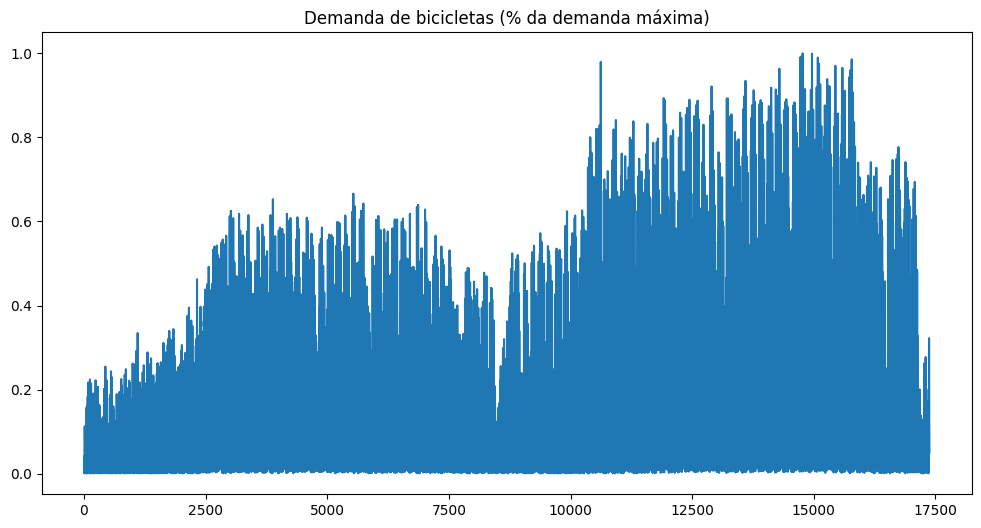

In [ ]:
# Preparação da variável target (y)
# O alvo escolhido é a fração da demanda máxima de bicicletas,
# em vez do número absoluto, por ser mais interpretável e comparável.
y_abs = df["count"].copy()
y = y_abs / y_abs.max()

# Por que prever a fração da demanda máxima e não o nº absoluto de bikes?
# - Normaliza os dados → evita que dias muito cheios ou vazios distorçam o modelo
# - Facilita comparações → 60% da demanda pode ser 180 bikes num dia de chuva ou 600 num dia de sol
# - Torna previsões mais úteis para planejamento → gestores pensam em % da demanda, não em nº fixo

# Visualização da série temporal do target normalizado
y.plot(figsize=(12, 6), title="Demanda de bicicletas (% da demanda máxima)")
plt.show()

- *Preparação das variáveis preditoras (X -> features)*

In [ ]:
# Preparação das variáveis preditoras (X)
# Todas as colunas exceto "count"
X = df.drop(columns=["count"]).copy()

# Análise do balanceamento das variáveis categóricas
print("\nDistribuição de valores por feature:")
for feature in X.columns:
    print("-" * 50)
    print(f"Feature: {feature}")
    print(X[feature].value_counts().sort_index())

# Ajuste de categorias escassas
# Reduzimos "heavy_rain" para "rain" para evitar classes muito raras
X["weather"] = (
    X["weather"].astype(object).replace("heavy_rain", "rain").astype("category")
)


Distribuição de valores por feature:
--------------------------------------------------
Feature: season
season
fall      4496
spring    4242
summer    4409
winter    4232
Name: count, dtype: int64
--------------------------------------------------
Feature: year
year
0    8645
1    8734
Name: count, dtype: int64
--------------------------------------------------
Feature: month
month
1     1429
2     1341
3     1473
4     1437
5     1488
6     1440
7     1488
8     1475
9     1437
10    1451
11    1437
12    1483
Name: count, dtype: int64
--------------------------------------------------
Feature: hour
hour
0     726
1     724
2     715
3     697
4     697
5     717
6     725
7     727
8     727
9     727
10    727
11    727
12    728
13    729
14    729
15    729
16    730
17    730
18    728
19    728
20    728
21    728
22    728
23    728
Name: count, dtype: int64
--------------------------------------------------
Feature: holiday
holiday
False    16879
True       500
Name: count, d

In [ ]:
# Validação após ajuste
print("Distribuição da variável 'weather' após ajuste:")
print(X["weather"].value_counts())

Distribuição da variável 'weather' após ajuste:
weather
clear    11413
misty     4544
rain      1422
Name: count, dtype: int64


### *EDA (Análise exploratória de dados)*

- *Identificação de padrões cíclicos nos dados*

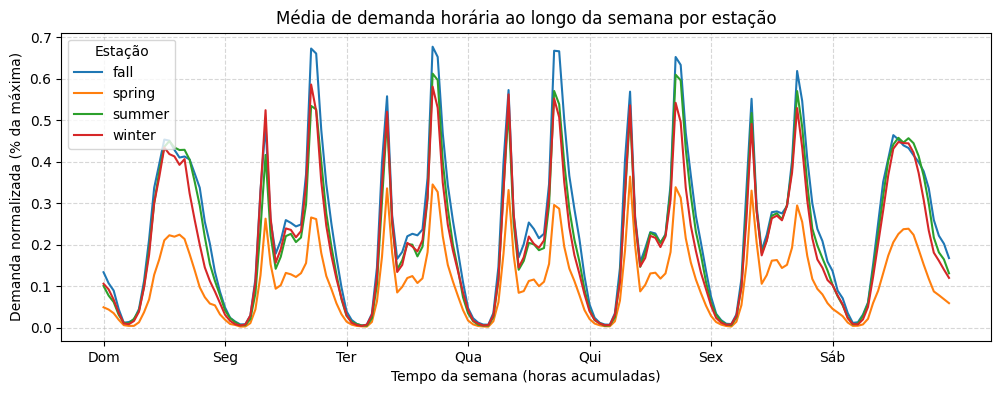

In [ ]:
# Calcula a demanda média por hora da semana, diferenciada por estação do ano
# Agrupamos por weekday (0=domingo,...,6=sábado), hora do dia e estação
average_week_demand = (
    df.groupby(["weekday", "hour", "season"])["count"]
    .mean()
    .reset_index()
)

# Criação da figura
fig, ax = plt.subplots(figsize=(12, 4))

# Plot de uma curva para cada estação
for season, data in average_week_demand.groupby("season", observed=True):
    ax.plot(
        data["weekday"] * 24 + data["hour"],  # converte para escala contínua em horas
        data["count"] / df["count"].max(),    # normaliza em percentual da demanda máxima
        label=season
    )

# Configurações do gráfico
ax.set(
    title="Média de demanda horária ao longo da semana por estação",
    xticks=[i * 24 for i in range(7)],
    xticklabels=["Dom", "Seg", "Ter", "Qua", "Qui", "Sex", "Sáb"],
    xlabel="Tempo da semana (horas acumuladas)",
    ylabel="Demanda normalizada (% da máxima)",
)
ax.legend(title="Estação")
ax.grid(True, linestyle="--", alpha=0.5)

# Exibir
plt.show()

Os resultados mostram variações claras ao longo da semana, com horários de pico bem definidos (como manhã e final da tarde), além de diferenças entre as estações — o que indica forte influência de fatores sazonais na utilização do sistema.

- *Análise de estacionariedade da série temporal*

In [ ]:
adf_test(df["count"])

 > Is the raw data stationary ?
Test statistic = -6.823
P-value = 0.000
Critical values :
	1%: -3.430727265144117 - The data is  stationary with 99% confidence
	5%: -2.8617067365231246 - The data is  stationary with 95% confidence
	10%: -2.5668587495404225 - The data is  stationary with 90% confidence


Série de dados é estacionária (sem tendência clara), removendo necessidades de transformações do tipo diferenciação para deixar a série estacionária

- *Distribuição dos dados*

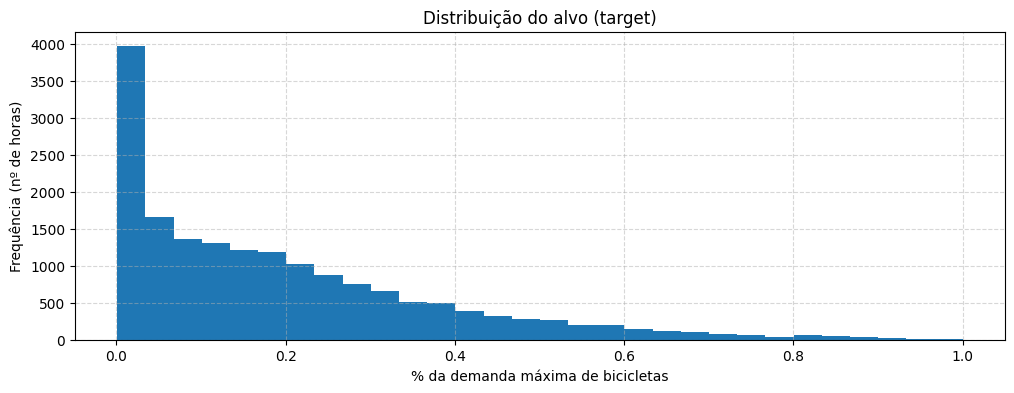

In [ ]:
# Distribuição do target (y)
fig, ax = plt.subplots(figsize=(12, 4))
y.hist(bins=30, ax=ax)
ax.set(
    title="Distribuição do alvo (target)",
    xlabel="% da demanda máxima de bicicletas",
    ylabel="Frequência (nº de horas)",
)
ax.grid(True, linestyle="--", alpha=0.5)
plt.show()

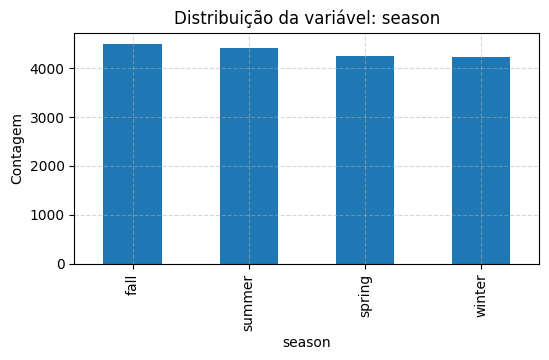

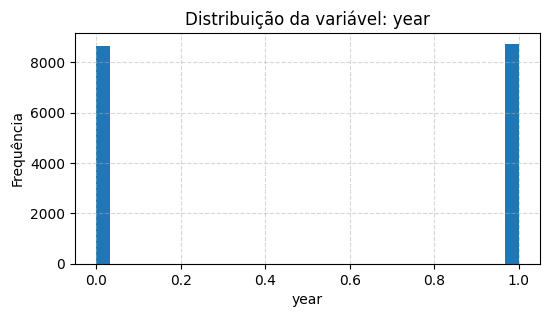

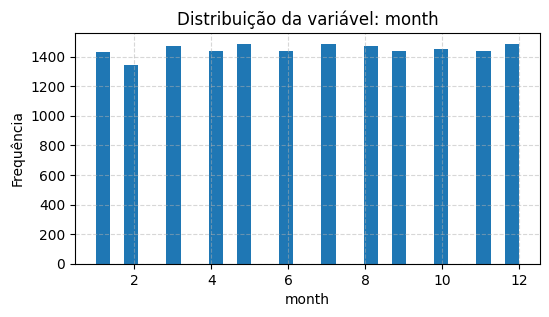

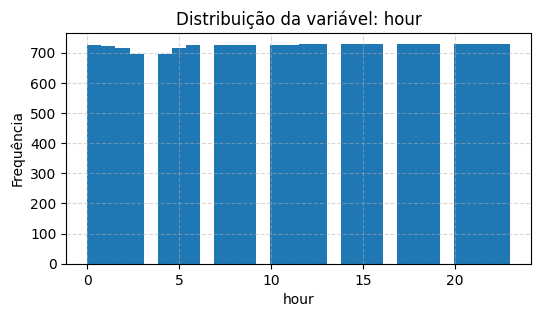

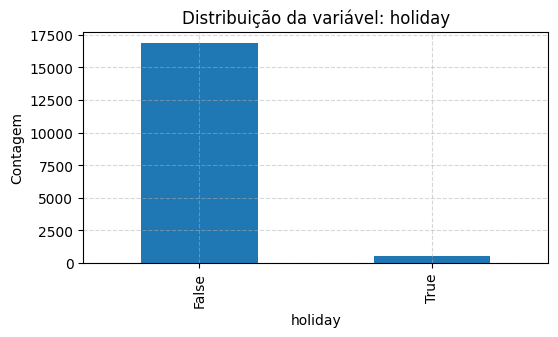

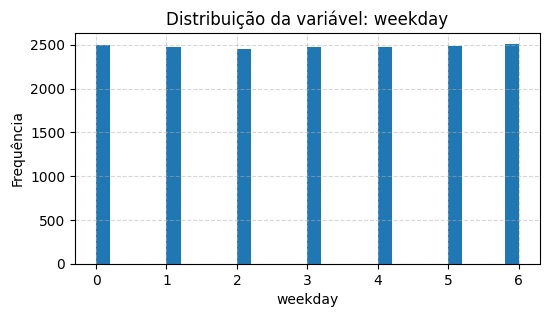

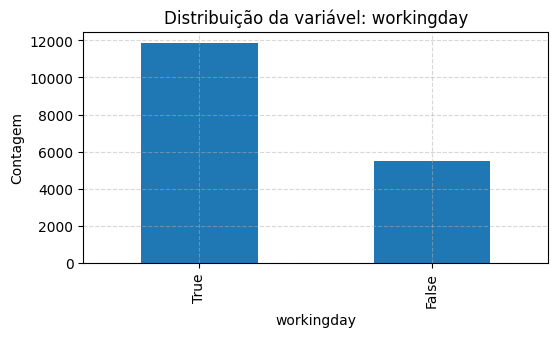

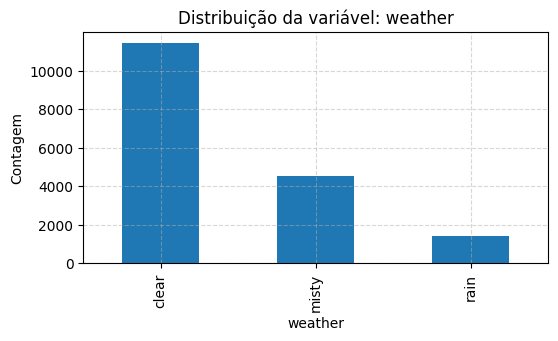

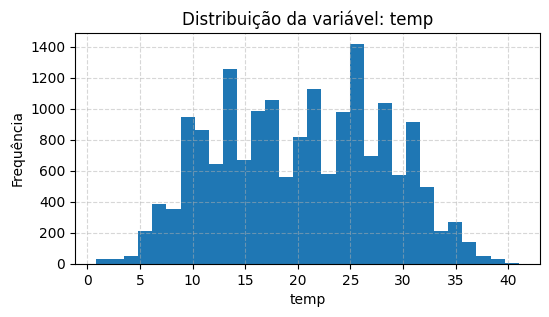

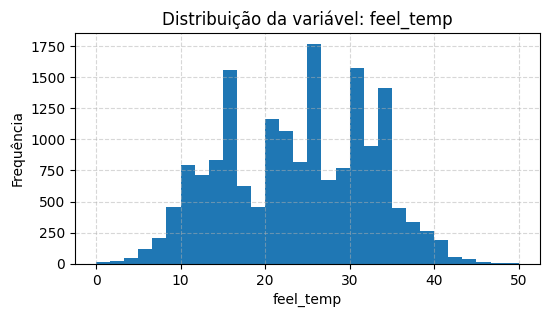

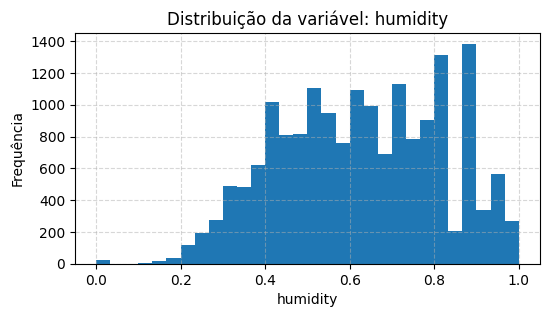

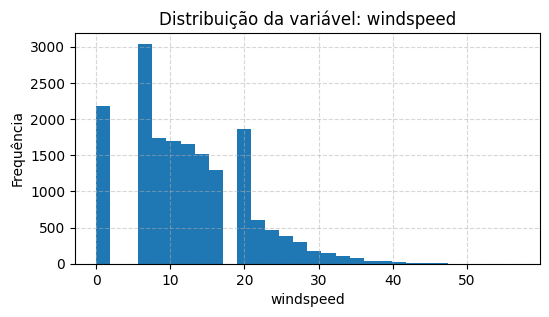

In [ ]:
# Distribuição das features
for feature in X.columns:
    fig, ax = plt.subplots(figsize=(6, 3))

    if pd.api.types.is_numeric_dtype(X[feature]):
        # Variáveis numéricas → histograma
        X[feature].hist(bins=30, ax=ax)
        ax.set(xlabel=feature, ylabel="Frequência")
    else:
        # Variáveis categóricas → gráfico de barras
        X[feature].value_counts().plot(kind="bar", ax=ax)
        ax.set(xlabel=feature, ylabel="Contagem")

    ax.set(title=f"Distribuição da variável: {feature}")
    ax.grid(True, linestyle="--", alpha=0.5)
    plt.show()


O target apresenta distribuição concentrada em níveis mais baixos de utilização (% da demanda máxima), indicando que a maioria dos períodos tem demanda reduzida, enquanto valores próximos à capacidade máxima são menos frequentes.

As variáveis numéricas e categóricas foram analisadas separadamente:

- As numéricas mostram dispersões variadas, revelando padrões horários e climáticos.
- As categóricas revelaram desbalanceamento em algumas classes, confirmando a necessidade de ajustes prévios (como a consolidação de heavy_rain em rain).

### *Feature engineering*

- *Codificação de variáveis cíclicas (encoding cyclical features)*

In [ ]:
# Criamos cópias para preservar os dados originais
X_fe = X.copy()
y_fe = y.copy()

In [ ]:
# Codificação cíclica das variáveis temporais
# Usamos sin/cos para capturar a natureza circular (ex.: hora 23 próximo da hora 0)
for col, period in [("hour", 24), ("weekday", 7), ("month", 12)]:
    X_fe[f"{col}_sin"] = np.sin(2 * np.pi * X_fe[col] / period)
    X_fe[f"{col}_cos"] = np.cos(2 * np.pi * X_fe[col] / period)

# Removemos as colunas originais para evitar redundância
X_fe.drop(columns=["month", "hour", "weekday"], inplace=True)

# Visualizamos amostra do resultado
print("Amostra das features após codificação cíclica:")
display(X_fe.head())

Amostra das features após codificação cíclica:


,season,year,holiday,workingday,weather,temp,feel_temp,humidity,windspeed,hour_sin,hour_cos,weekday_sin,weekday_cos,month_sin,month_cos
0,spring,0,False,False,clear,9.84,14.395,0.81,0.0,0.000000,1.000000,-0.781831,0.62349,0.5,0.866025
1,spring,0,False,False,clear,9.02,13.635,0.80,0.0,0.258819,0.965926,-0.781831,0.62349,0.5,0.866025
2,spring,0,False,False,clear,9.02,13.635,0.80,0.0,0.500000,0.866025,-0.781831,0.62349,0.5,0.866025
3,spring,0,False,False,clear,9.84,14.395,0.75,0.0,0.707107,0.707107,-0.781831,0.62349,0.5,0.866025
4,spring,0,False,False,clear,9.84,14.395,0.75,0.0,0.866025,0.500000,-0.781831,0.62349,0.5,0.866025


### *Análise de **autocorrelação** para criação de **Rolling and Lagged Features***

1) Primeiro calculamos e visualizamos ACF e PACF até 7 dias de defasagem.

2) Em seguida, selecionamos automaticamente os lags mais relevantes (via PACF) e as janelas de médias móveis (via ACF).

3) Definimos restrições para evitar vazamento de informação:
    - Usar lags ≥ 24h → garante que a previsão nunca dependa do mesmo dia.

    - Usar janelas ≥ 48h → evita incluir médias que “olhem” para o futuro próximo.

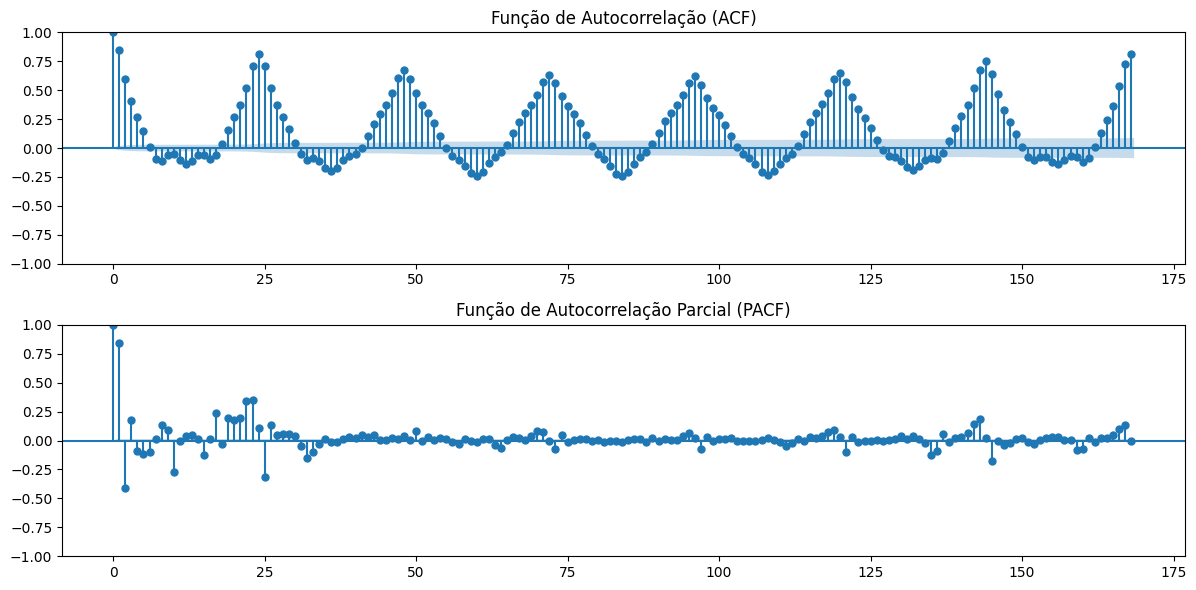

Amostra das autocorrelações (até 7 dias):
    autocorrelation_abs  partial_autocorrelation_abs
1              0.843774                     0.843823
2              0.594070                     0.409420
3              0.404356                     0.180623
4              0.272212                     0.086889
5              0.145557                     0.119259
6              0.010242                     0.098018
7              0.093143                     0.012415
8              0.112709                     0.130798
9              0.058127                     0.091118
10             0.053529                     0.273649


In [ ]:
# Definimos horizonte máximo de análise (7 dias passados em dados horários)
n_lags = 24 * 7

# --- 1. Gráficos de autocorrelação ---
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plot_acf(y_fe, lags=n_lags, ax=plt.gca())
plt.title("Função de Autocorrelação (ACF)")

plt.subplot(2, 1, 2)
plot_pacf(y_fe, lags=n_lags, ax=plt.gca())
plt.title("Função de Autocorrelação Parcial (PACF)")

plt.tight_layout()
plt.show()

# --- 2. Cálculo dos valores numéricos ---
autocorrelation = acf(y_fe, nlags=n_lags)
partial_autocorrelation = pacf(y_fe, nlags=n_lags)

autocorrelation_df = pd.DataFrame(
    {
        "autocorrelation_abs": np.abs(autocorrelation),
        "partial_autocorrelation_abs": np.abs(partial_autocorrelation),
    },
    index=range(n_lags + 1)
).iloc[1:]  # remove lag 0 (correlação perfeita com ele mesmo)

print("Amostra das autocorrelações (até 7 dias):")
print(autocorrelation_df.head(10))

In [ ]:
# --- 3. Seleção de lags e janelas ---
# Critério: escolhemos as 2 maiores correlações parciais (lags mais relevantes)
# Restrição: considerar apenas lags >= 24h para evitar dependência do mesmo dia
chosen_lags = autocorrelation_df.loc[24:, "partial_autocorrelation_abs"].sort_values(
    ascending=False
)
print(
    f"Lags escolhidos (para Lagged Features): {chosen_lags.index[0:2].to_list()}"
)

# Critério: escolhemos as 2 maiores autocorrelações (rolling windows mais informativas)
# Restrição: considerar apenas lags >= 48h (mínimo 2 dias para trás)
chosen_windows = autocorrelation_df.loc[48:, "autocorrelation_abs"].sort_values(
    ascending=False
)
print(
    f"Janelas escolhidas (para Rolling Features): {chosen_windows.index[0:2].to_list()}"
)

Lags escolhidos (para Lagged Features): [25, 143]
Janelas escolhidas (para Rolling Features): [168, 144]


A análise de autocorrelação foi conduzida até 7 dias de defasagem. A PACF identificou os lags mais relevantes, a partir de 24h, para evitar dependência do mesmo dia. Já a ACF foi usada para selecionar as janelas de médias móveis mais informativas, considerando apenas janelas ≥ 48h.
Esse procedimento garante rigor estatístico e evita data leakage.

- *Criação de features temporais (Lagged e Rolling)*

In [ ]:
# Lags escolhidos (em horas) com base na PACF
lags = (25, 143)

# Janelas móveis escolhidas (em horas) com base na ACF
# Obs: usamos shift(24) -> cálculo começa 1 dia atrás (evita usar dados do próprio dia)
# 168 - 24 = 144 / 144 - 24 = 120
windows = (144, 120)

# Variáveis climáticas usadas para criar lagged e rolling features
past_related_features = ["temp", "feel_temp", "humidity", "windspeed"]

# --- 1. Criação de Lagged Features ---
for lag in lags:
    # Variáveis preditoras (meteorológicas)
    for feature in past_related_features:
        X_fe[f"{feature}_lag_{lag}h"] = X_fe[feature].shift(lag)
    # Alvo (demanda)
    X_fe[f"count_lag_{lag}h"] = y_fe.shift(lag)

# --- 2. Criação de Rolling Features ---
for window in windows:
    # Variáveis preditoras (médias e desvios móveis)
    for feature in past_related_features:
        X_fe[f"{feature}_roll_mean_{window}h"] = (
            X_fe[feature].shift(24).rolling(window).mean()
        )
        X_fe[f"{feature}_roll_std_{window}h"] = (
            X_fe[feature].shift(24).rolling(window).std()
        )
    # Alvo (médias e desvios móveis da demanda)
    X_fe[f"roll_mean_{window}h"] = y_fe.shift(24).rolling(window).mean()
    X_fe[f"roll_std_{window}h"] = y_fe.shift(24).rolling(window).std()

# --- 3. Limpeza de dados ---
# Removemos variáveis originais já transformadas
X_fe.drop(columns=past_related_features, inplace=True)

# Removemos linhas com NaN (geradas por lags/rollings iniciais)
valid = X_fe.dropna().index
X_fe = X_fe.loc[valid]
y_fe = y_fe.loc[valid]

# --- 4. Prevenção de vazamento adicional ---
# Variável "weather" não pode ser usada (informação futura não disponível)
X_fe.drop(columns=["weather"], inplace=True)

# --- 5. Visualização final das features ---
print(f"Formato final de X_fe: {X_fe.shape}")
display(X_fe.head())

Formato final de X_fe: (17212, 40)


,season,year,holiday,workingday,hour_sin,hour_cos,weekday_sin,weekday_cos,month_sin,month_cos,...,temp_roll_mean_120h,temp_roll_std_120h,feel_temp_roll_mean_120h,feel_temp_roll_std_120h,humidity_roll_mean_120h,humidity_roll_std_120h,windspeed_roll_mean_120h,windspeed_roll_std_120h,roll_mean_120h,roll_std_120h
167,spring,0,False,False,1.000000,6.123234e-17,-0.781831,0.62349,0.5,0.866025,...,9.710167,3.269640,12.146708,3.725027,0.542750,0.159358,12.283780,7.254373,0.059562,0.054080
168,spring,0,False,False,0.965926,-2.588190e-01,-0.781831,0.62349,0.5,0.866025,...,9.621333,3.161998,12.045708,3.597940,0.541167,0.156904,12.192102,7.225503,0.060133,0.053993
169,spring,0,False,False,0.866025,-5.000000e-01,-0.781831,0.62349,0.5,0.866025,...,9.539333,3.068036,11.944708,3.485361,0.537583,0.152569,12.192102,7.225503,0.061779,0.055664
170,spring,0,False,False,0.707107,-7.071068e-01,-0.781831,0.62349,0.5,0.866025,...,9.464167,2.987723,11.843708,3.388885,0.533167,0.146626,12.200421,7.233979,0.062845,0.055874
171,spring,0,False,False,0.500000,-8.660254e-01,-0.781831,0.62349,0.5,0.866025,...,9.382167,2.859983,11.736417,3.242123,0.528417,0.142510,12.275461,7.288818,0.063332,0.055630


Foram incluídas variáveis defasadas (lags) e médias/desvios móveis (rolling) tanto do alvo quanto das variáveis climáticas. Os lags escolhidos foram de 25h e 143h, e as janelas móveis foram de 120h e 144h, definidos previamente pela análise de autocorrelação (ACF/PACF).

Todas as transformações foram implementadas com deslocamento mínimo de 24h, garantindo que apenas informações passadas fossem utilizadas. Além disso, a variável weather foi removida por não ser conhecida no momento da previsão real.

### *Avaliação de features*

In [ ]:
# Buscar apenas features numéricas
numerical_features = X_fe.select_dtypes(include=np.number).columns.tolist()
print(numerical_features)

# Buscar apenas features categóricas
categorical_features = X_fe.drop(columns=numerical_features).columns.tolist()
print(categorical_features)

['year', 'hour_sin', 'hour_cos', 'weekday_sin', 'weekday_cos', 'month_sin', 'month_cos', 'temp_lag_25h', 'feel_temp_lag_25h', 'humidity_lag_25h', 'windspeed_lag_25h', 'count_lag_25h', 'temp_lag_143h', 'feel_temp_lag_143h', 'humidity_lag_143h', 'windspeed_lag_143h', 'count_lag_143h', 'temp_roll_mean_144h', 'temp_roll_std_144h', 'feel_temp_roll_mean_144h', 'feel_temp_roll_std_144h', 'humidity_roll_mean_144h', 'humidity_roll_std_144h', 'windspeed_roll_mean_144h', 'windspeed_roll_std_144h', 'roll_mean_144h', 'roll_std_144h', 'temp_roll_mean_120h', 'temp_roll_std_120h', 'feel_temp_roll_mean_120h', 'feel_temp_roll_std_120h', 'humidity_roll_mean_120h', 'humidity_roll_std_120h', 'windspeed_roll_mean_120h', 'windspeed_roll_std_120h', 'roll_mean_120h', 'roll_std_120h']
['season', 'holiday', 'workingday']


- *Análise de correlações*

<Axes: >

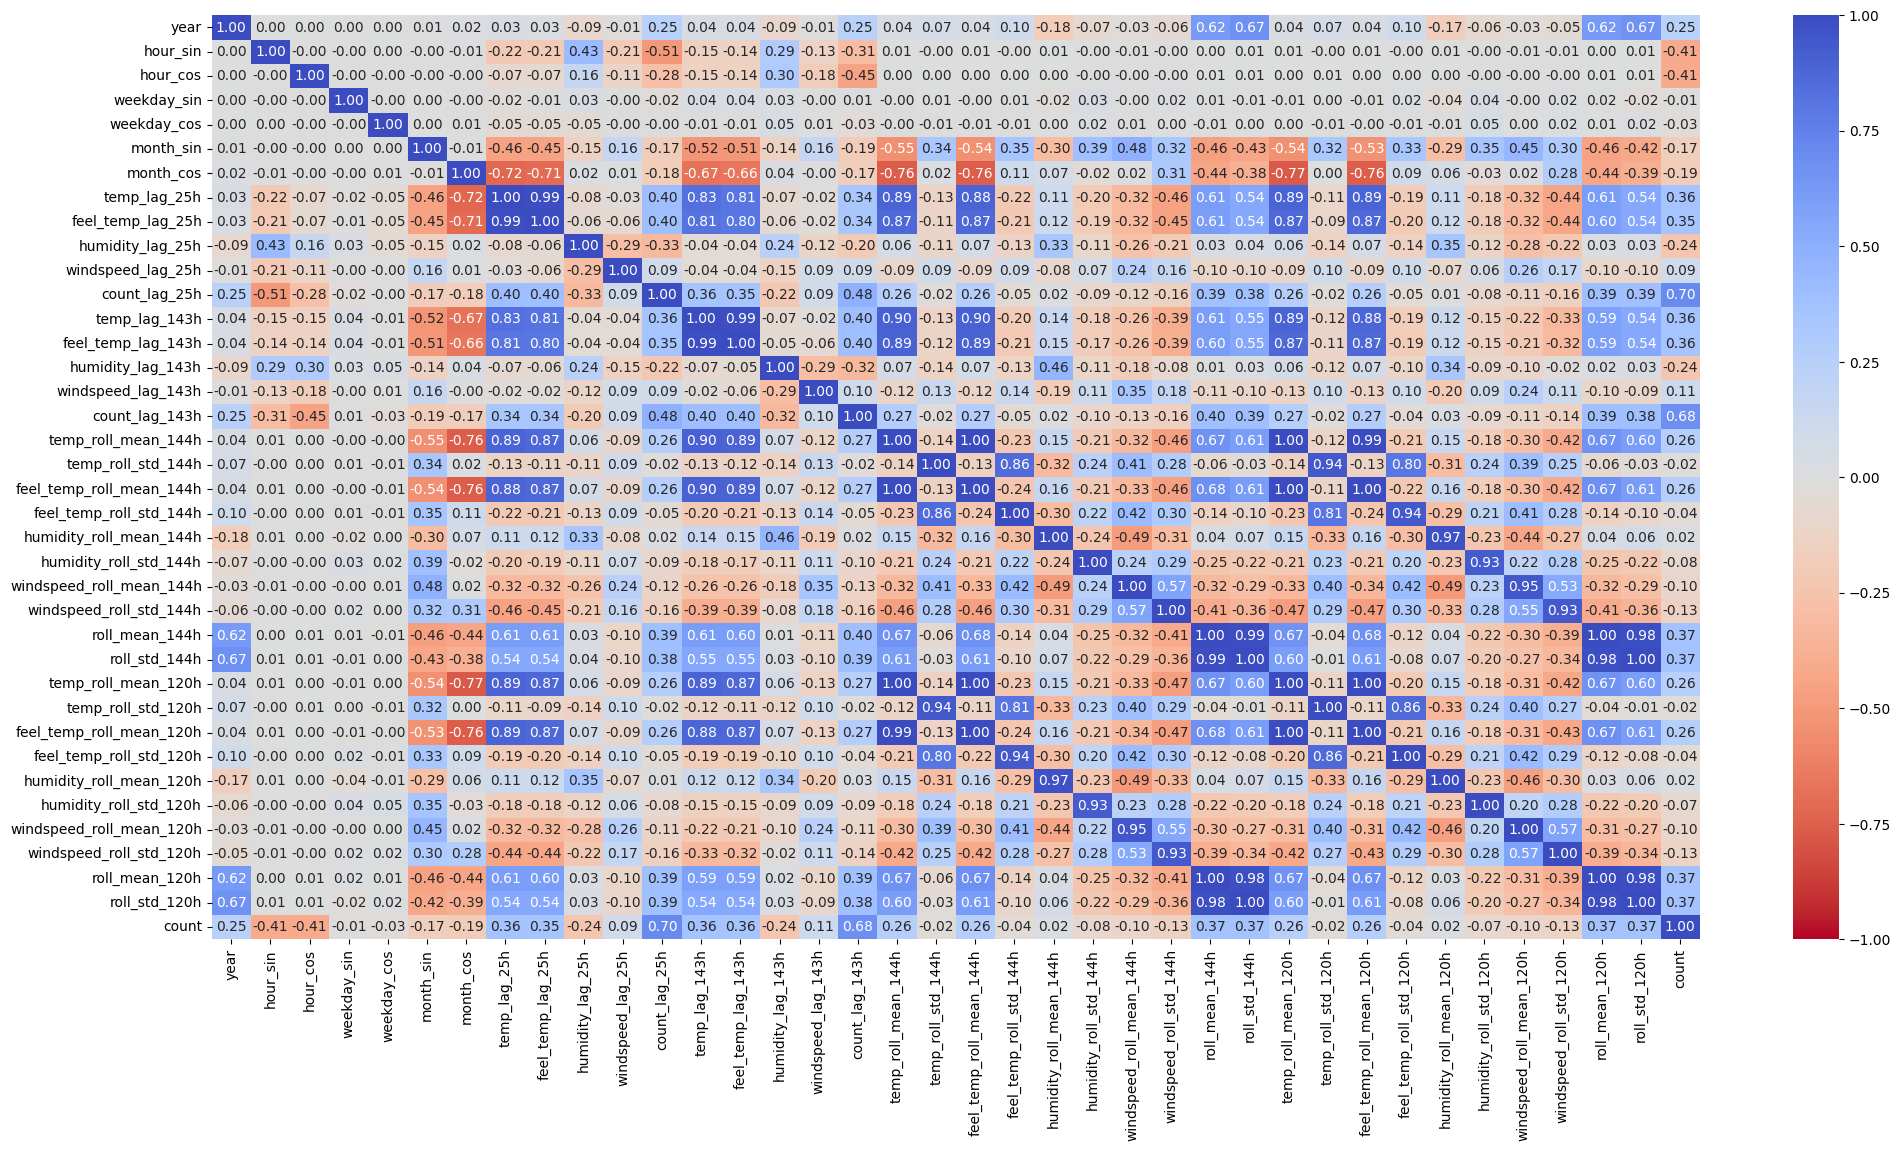

In [ ]:
# Cria figura
fig, ax = plt.subplots(figsize=(24, 12))

# Cálculo de correlações entre features (apenas numéricas) e target
corr = pd.concat([X_fe, y_fe], axis=1).corr(numeric_only=True)

# Heatmap para visualização
sns.heatmap(
    corr,
    annot=True,
    vmin=-1,
    vmax=1,
    cmap="coolwarm_r",
    ax=ax,
    fmt=".2f",
)

### *Treinamento e avaliação de modelos*

- *Estratégia de validação cruzada (cross-validation) para séries temporais*

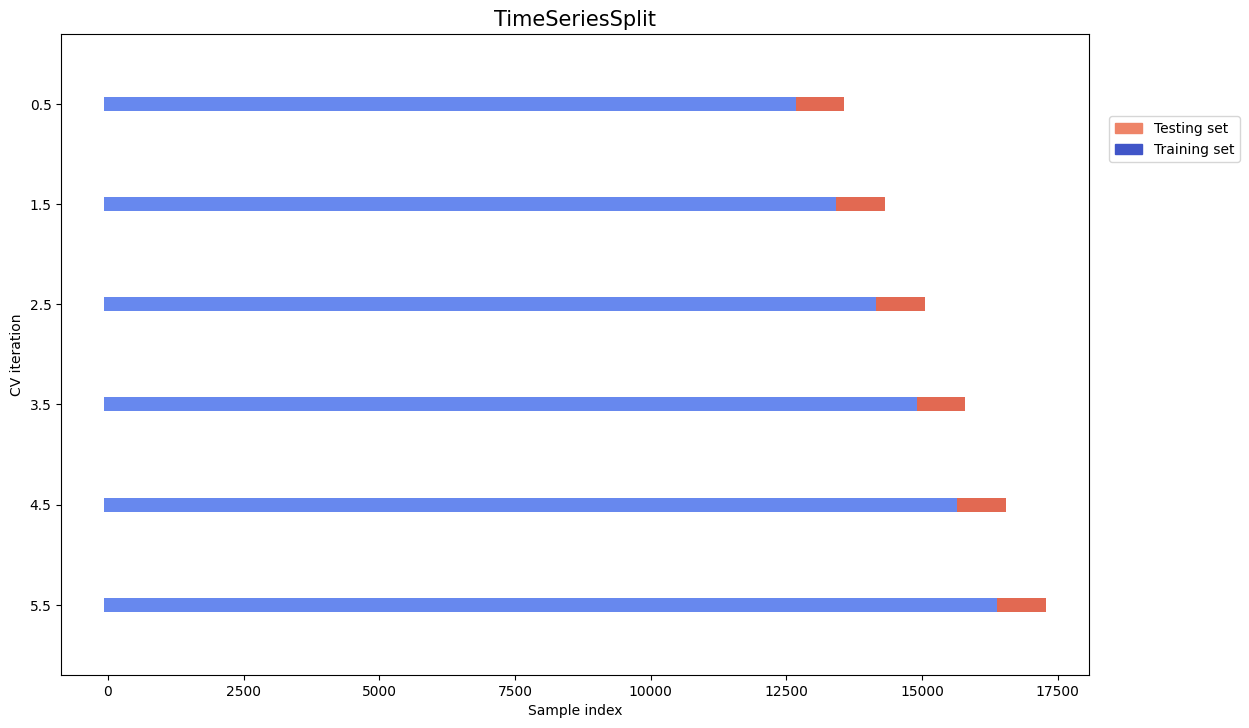

In [ ]:
# Criamos objeto de validação cruzada específico para séries temporais
# - Mantém ordem temporal dos dados
# - Evita usar dados do futuro no treino
# - Crescimento progressivo da janela de treino
tss = TimeSeriesSplit(
    n_splits=6,          # número de divisões (6 meses de teste)
    test_size=24 * 31    # tamanho do conjunto de teste ≈ 1 mês de dados horários
)
# --- Visualização da estratégia de CV ---
# Essa função auxilia a entender como os índices são divididos
plot_cv_indices(X_fe, y_fe, cv=tss, n_splits=6)

- *Criação de pré-processadores e pipelines para diferentes modelos candidatos*

In [ ]:
# --------- 1. Pré-processadores ---------
# Linear/Tree com OHE (one-hot encoding)
preprocessor_ohe = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numerical_features),
        (
            "cat",
            OneHotEncoder(handle_unknown="ignore", sparse_output=False),
            categorical_features,
        ),
    ],
    remainder="drop",
)

# HistGradientBoosting (categorias inteiras)
preprocessor_hgb = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numerical_features),
        (
            "cat",
            OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1),
            categorical_features,
        ),
    ],
    remainder="drop",
)

# Redes neurais (MinMax + OHE)
preprocessor_nn = ColumnTransformer(
    transformers=[
        ("num", MinMaxScaler(), numerical_features),
        (
            "cat",
            OneHotEncoder(handle_unknown="ignore", sparse_output=False),
            categorical_features,
        ),
    ],
    remainder="drop",
)

# --------- 2. Seleção de features ---------
linear_feature_selection = SelectPercentile(score_func=f_regression, percentile=60)
non_linear_feature_selection = SelectPercentile(
    score_func=mutual_info_regression, percentile=60
)

# OBSERVAÇÃO SOBRE FEATURE SELECTION
# Nenhum modelo neste projeto utiliza seleção de features explícita (SelectPercentile),
# pois todos os modelos escolhidos possuem mecanismos embutidos de seleção ou penalização:
# - ElasticNet aplica regularização L1+L2, descartando features irrelevantes automaticamente.
# - RandomForest e LGBM, por serem ensembles de árvores, priorizam features importantes durante o treinamento.
# Essa abordagem simplifica o pipeline, evita redundâncias e mantém interpretabilidade e performance.


# --------- 3. Pipelines de modelos ---------
model_configs = {
    # Linear models
    "ENET": Pipeline(
        [
            ("preproc", preprocessor_ohe),
            # ("feat_sel", linear_feature_selection), # opcional
            (
                "reg",
                ElasticNetCV(
                    cv=tss, random_state=42, l1_ratio=[0.1, 0.5, 0.9], max_iter=1000
                ),
            ),
        ]
    ),
    # Neural networks
    "NN": Pipeline(
        [
            ("preproc", preprocessor_nn),
            # ("feat_sel", non_linear_feature_selection),  # opcional
            (
                "reg",
                MLPRegressor(
                    random_state=42,
                    solver="adam",
                    hidden_layer_sizes=(30, 15),
                    activation="relu",
                    learning_rate_init=1e-3,
                    early_stopping=True,
                    validation_fraction=0.1,
                    alpha=1e-4,
                    max_iter=1000,
                    tol=1e-4,
                ),
            ),
        ]
    ),
    # Tree ensembles
    "RF": Pipeline(
        [
            ("preproc", preprocessor_ohe),
            (
                "reg",
                RandomForestRegressor(
                    random_state=42,
                    n_estimators=300,
                    max_depth=10,
                    max_features="sqrt",
                ),
            ),
        ]
    ),
    "LGBM": Pipeline(
        [
            ("preproc", preprocessor_ohe),
            (
                "reg",
                LGBMRegressor(
                    random_state=42,
                    n_estimators=1000,
                    learning_rate=0.05,
                    num_leaves=31,
                    colsample_bytree=0.8,
                    subsample=0.8,
                    reg_alpha=0.1,
                    reg_lambda=1.0,
                    verbosity=-1,
                ),
            ),
        ]
    ),
    # HistGradientBoosting (suporte nativo a categorias)
    "HGB": Pipeline(
        [
            ("preproc", preprocessor_hgb),
            (
                "reg",
                HistGradientBoostingRegressor(
                    random_state=42, max_iter=1000, max_depth=10, learning_rate=0.05
                ),
            ),
        ]
    ),
}
models = list(model_configs.items())

1) Para cada família de modelo, criamos pré-processadores adequados às suas necessidades:

    - Linear e árvores tradicionais → one-hot e escalonamento.
    - HistGradientBoosting → categorias como inteiros.
    - Redes neurais → MinMaxScaler + OHE.

2) Os pipelines incluem pré-processamento, seleção de features (quando aplicável) e o regressor final.

3) Essa abordagem garante consistência, facilita comparações entre modelos e evita vazamento de dados durante o treinamento.

- *Avaliação de modelos candidatos (cross-validation)*

ENET: -0.093585 (0.007940)
NN: -0.060190 (0.005541)
RF: -0.078547 (0.006538)
LGBM: -0.058935 (0.002612)
HGB: -0.057729 (0.003021)


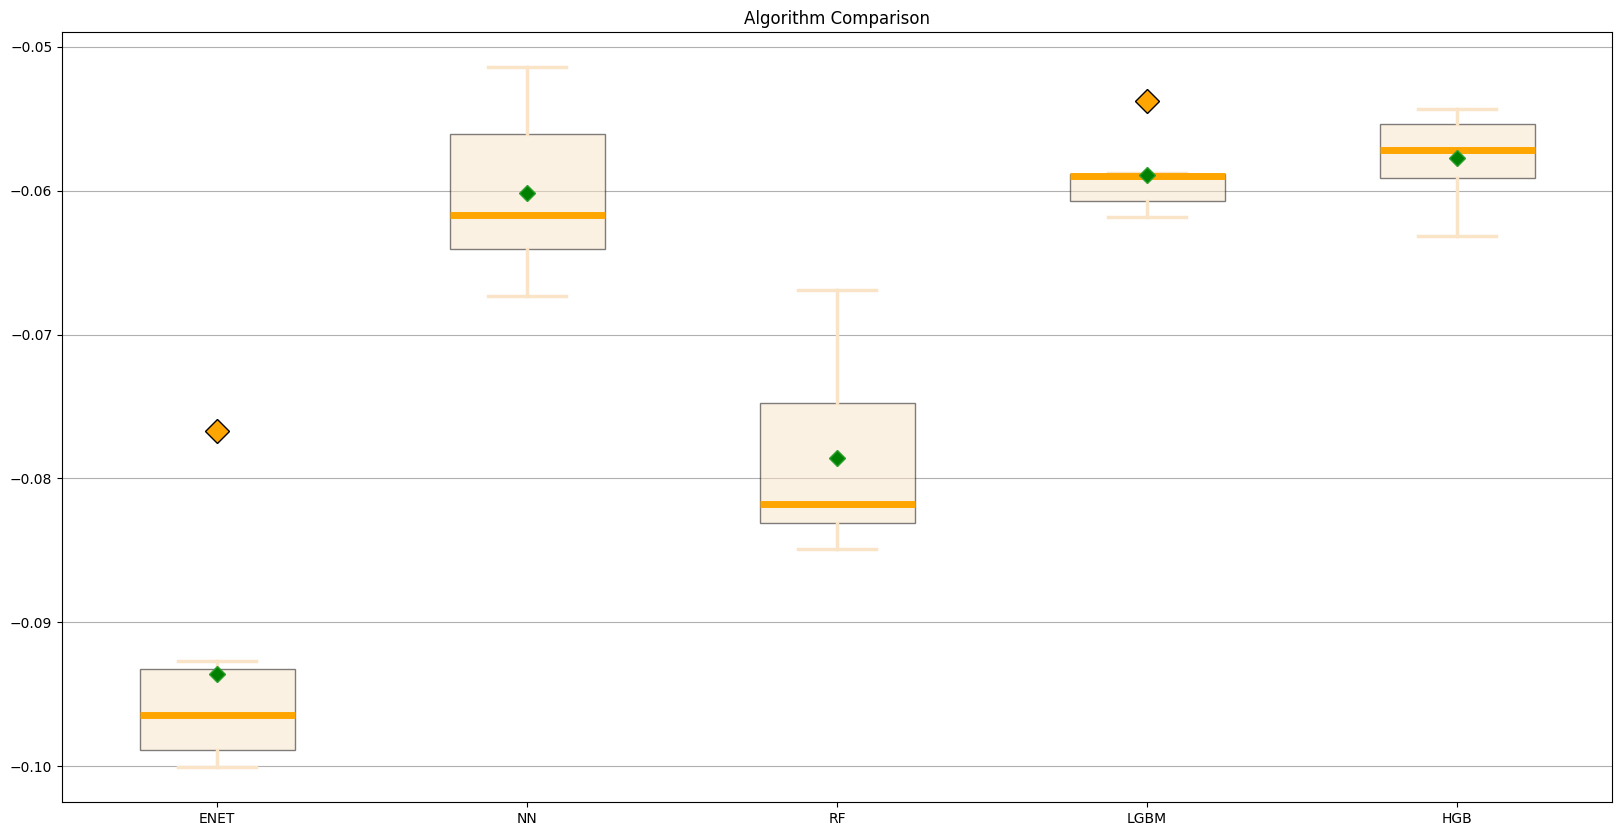

In [ ]:
# Erro médio absoluto
plot_cross_val_scores(
    models=models,
    X=X_fe,
    y=y_fe,
    cv=tss,
    scoring="neg_mean_absolute_error",
)

ENET: 0.601437 (0.088890)
NN: 0.813474 (0.070341)
RF: 0.724376 (0.065433)
LGBM: 0.821183 (0.058423)
HGB: 0.826945 (0.055419)


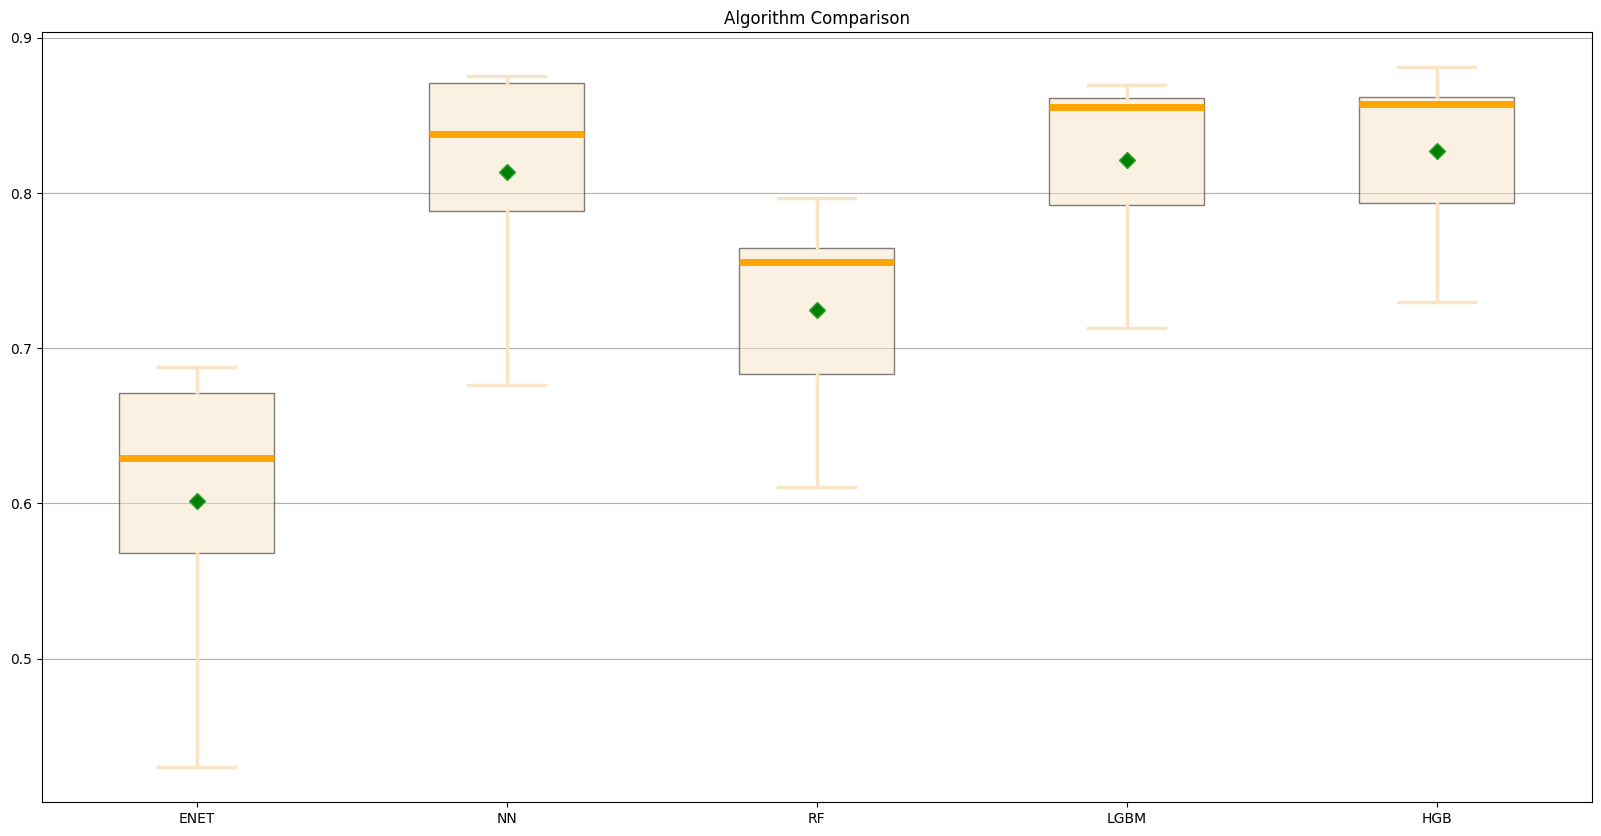

In [ ]:
# R²
plot_cross_val_scores(
    models=models,
    X=X_fe,
    y=y_fe,
    cv=tss,
    scoring="r2",
)

**Seleção do Modelo Final**

Após avaliação via validação cruzada, observou-se que o modelo **MLP (NN)** apresentou uma combinação equilibrada de alta acurácia e baixa variabilidade:

- **MAE:** o erro médio da NN (6%) foi baixo e consistente (desvio padrão 0.5%), indicando previsões precisas e estáveis.  
- **R²:** a NN alcançou 0.813, mostrando excelente capacidade de capturar a variabilidade da demanda, com desvio padrão razoável (0.070), evidenciando boa generalização.

Embora os modelos **LGBM** e **HGB** tenham apresentado valores ligeiramente superiores de R², optou-se pela rede neural devido ao compromisso entre **desempenho e interpretabilidade da arquitetura**

### *Treinamento e Avaliação do Modelo final*

- *Separação de dados em treino e teste*

In [ ]:
# Separação dos dados em treino (70%) e teste (30%),
# preservando temporalidade dos dados e não de forma aleatória (tradicional),
# pois estamos modelando séries temporais (evitar vazamento de informações futuras)
train_size = int(len(X_fe) * 0.7)

X_train = X_fe.iloc[:train_size]
X_test = X_fe.iloc[train_size:]
y_train = y_fe[:train_size]
y_test = y_fe[train_size:]

- *Validação final do modelo*

> Modelo selecionado: MLP (redes neurais)

In [ ]:
# ----- Treinamento do modelo -----
# Ajusta o modelo MLP com os dados de treino
final_model = model_configs["NN"]
final_model.fit(X_train, y_train)

# ----- Previsões -----
# Gerar previsões para treino e teste
pred_train = final_model.predict(X_train)
pred_test = final_model.predict(X_test)

# ----- Avaliação de desempenho -----
# Função customizada: calcula MAE, R², RMSE e BIAS
results_train = regression_metrics(y_train, pred_train)
results_test = regression_metrics(y_test, pred_test)

# Combina resultados em único DataFrame para fácil visualização
results_df = pd.DataFrame({
    **{f"{k} - Train": v for k, v in results_train.items()},
    **{f"{k} - Test": v for k, v in results_test.items()},
}, index=[0])
display(results_df)

,MAE - Train,R² - Train,RMSE - Train,BIAS - Train,MAE - Test,R² - Test,RMSE - Test,BIAS - Test
0,0.03,0.9,0.05,0.003,0.07,0.82,0.1,-0.001


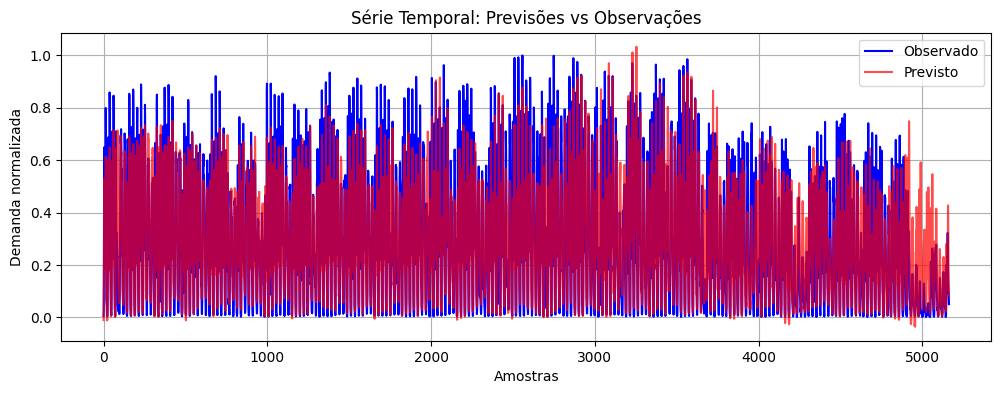

In [ ]:
# ----- Visualização 1: Série temporal -----
# Compara observações vs previsões ao longo do tempo
plt.figure(figsize=(12,4))
plt.plot(y_test.values, label="Observado", color="blue")
plt.plot(pred_test, label="Previsto", color="red", alpha=0.7)
plt.xlabel("Amostras")
plt.ylabel("Demanda normalizada")
plt.title("Série Temporal: Previsões vs Observações")
plt.legend()
plt.grid(True)
plt.show()

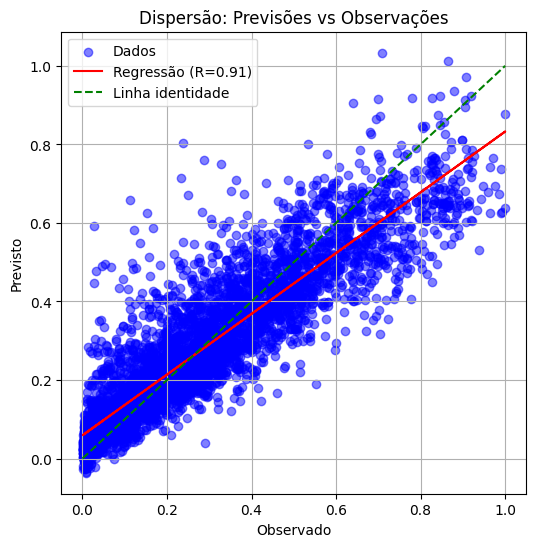

In [ ]:
# ----- Visualização 2: Gráfico de dispersão com linha de regressão -----
# Permite avaliar linearidade e correlação entre observado e previsto
slope, intercept, r_value, p_value, std_err = linregress(y_test, pred_test)

plt.figure(figsize=(6,6))
plt.scatter(y_test, pred_test, alpha=0.5, color="blue", label="Dados")
plt.plot(y_test, slope*y_test + intercept, color="red",
         label=f"Regressão (R={r_value:.2f})")
plt.plot([0,1],[0,1], "g--", label="Linha identidade")  # linha perfeita
plt.xlabel("Observado")
plt.ylabel("Previsto")
plt.title("Dispersão: Previsões vs Observações")
plt.legend()
plt.grid(True)
plt.show()

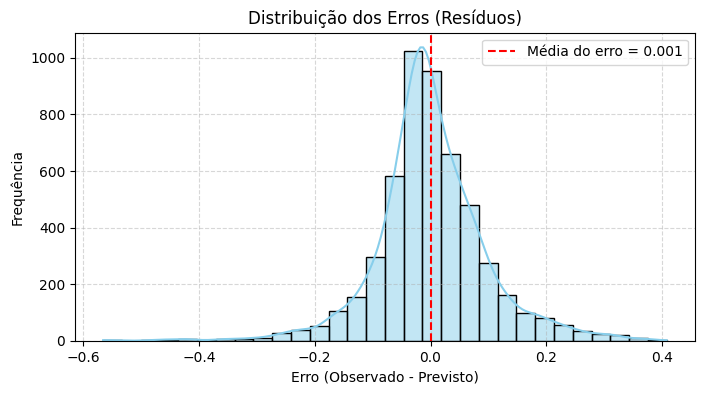

In [ ]:
# ----- Visualização 3: Gráfico de distribuição de erro -----
# Calcular resíduos
residuals = y_test - pred_test

# Figura
plt.figure(figsize=(8, 4))

# Histograma + densidade
sns.histplot(residuals, bins=30, kde=True, color="skyblue", edgecolor="black")

# Configurações do gráfico
plt.title("Distribuição dos Erros (Resíduos)")
plt.xlabel("Erro (Observado - Previsto)")
plt.ylabel("Frequência")
plt.grid(True, linestyle="--", alpha=0.5)
plt.axvline(
    residuals.mean(),
    color="red",
    linestyle="--",
    label=f"Média do erro = {residuals.mean():.3f}",
)
plt.legend()
plt.show()

- *Finalização do modelo*

In [ ]:
# Treina o modelo MLP com todo o dataset disponível (X_fe e y_fe)
final_model.fit(X_fe, y_fe)
print("Modelo finalizado!")

Modelo finalizado!


# Conclusões gerais do projeto

O modelo **MLP** apresenta excelente desempenho tanto em treino quanto em teste, evidenciado por:

- **Alto R²**: 0,898 no treino e 0,819 no teste, indicando que o modelo consegue capturar a maior parte da variabilidade da demanda de bikes, mantendo boa **capacidade de generalização**.
- **Erros baixos (MAE e RMSE)**: MAE de 3,4% no treino e 6,8% no teste, confirmando precisão satisfatória, mesmo em dados fora da amostra de treinamento.
- **Bias mínimo**: valores próximos de zero indicam que o modelo não apresenta tendência sistemática a superestimar ou subestimar a demanda.
    - Observa-se um pequeno **viés de subestimação no teste**, que pode ser corrigido posteriormente via pós-processamento ou ajuste de calibração.

## Justificativa sobre hiperparametrização

- Neste estágio, **não foi realizado GridSearch ou RandomizedSearch** para otimização de hiperparâmetros.
- As configurações iniciais já apresentaram resultados satisfatórios, evitando sobrecarga computacional e mantendo **pipelines simples e interpretáveis**.
- A **hiperparametrização** é considerada uma melhoria futura, caso se deseje aumentar ainda mais a acurácia ou reduzir erros residuais.

## Análise da distribuição de erro

- Os resíduos do modelo (diferença entre observado e previsto) são **centralizados em torno de zero** e apresentam dispersão limitada, indicando previsões equilibradas e ausência de padrões sistemáticos de erro.
- Pequenos desvios em horários ou condições extremas podem ser tratados posteriormente com técnicas de **correção de bias** ou ajuste contextual (ex.: clima, feriados).

## Verificação de Overfitting e Underfitting

A comparação entre métricas de treino e teste sugere que **não há sinais claros de overfitting ou underfitting**:

- O **R² de treino (0,898)** é levemente superior ao **R² de teste (0,819)**, indicando que o modelo captura bem a variabilidade dos dados sem memorizar padrões específicos do treino.  
- Os **erros MAE e RMSE** aumentam de forma moderada do treino para o teste, mostrando que o modelo mantém **boa precisão fora da amostra de treinamento**.  
- A análise da **distribuição dos resíduos** reforça essa conclusão, já que os erros estão centralizados em torno de zero e não apresentam padrões sistemáticos ou tendências crescentes/decrescentes.

Portanto, o modelo MLP consegue **generalizar adequadamente** para novos dados, fornecendo previsões confiáveis sem indicar underfitting (modelo muito simples) nem overfitting (modelo excessivamente complexo).

## Conclusão prática

- O modelo é **suficientemente preciso para planejamento de operação e gestão de frota de bikes**.
- A combinação de **feature engineering cíclica, lags e rolling features** contribuiu para capturar padrões temporais importantes sem a necessidade de ajustes complexos de hiperparâmetros nesta etapa.

## Futuras Melhorias

- **Correção de bias**: ajustes pós-processamento para reduzir subestimações / superestimações (viés) em determinadas janelas de previsão.
- **Hiperparametrização**: GridSearch ou RandomizedSearch para encontrar configurações ideais de MLP ou outros modelos.
- **Modelos mais avançados**: testar redes LSTM, GRU ou técnicas de Stacking/Ensembling para capturar dependências temporais mais complexas.
- **Aprimoramento de features**: inclusão de novas variáveis externas ou transformação de features existentes.
- **Avaliação contínua**: monitoramento em produção com atualização periódica do modelo para adaptação a mudanças de padrão de demanda.